In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

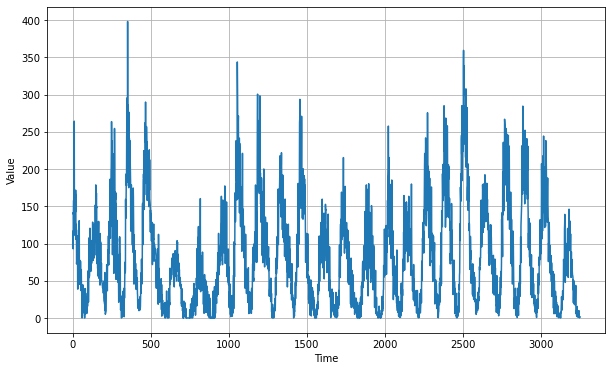

In [3]:
import csv
time_step = []
sunspots = []

with open('C:/Users/Teja/Desktop/dsml/tensorflow_training/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

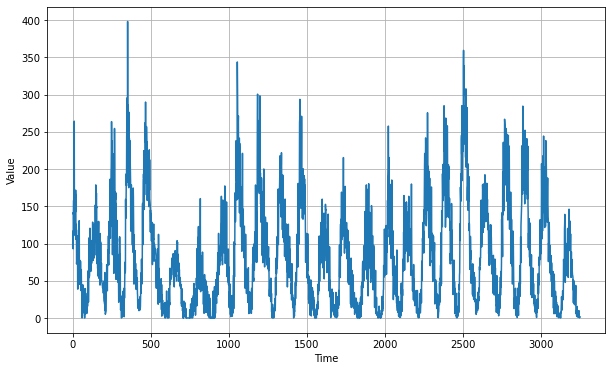

In [4]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 5s 382ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 4s 328ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 4s 359ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 4s 345ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 4s 347ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 4s 341ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 4s 370ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 4s 328ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 4s 352ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/

12/12 [==============================] - 4s 339ms/step - loss: 20.0854 - mae: 20.5786
Epoch 83/100
12/12 [==============================] - 4s 333ms/step - loss: 33.2586 - mae: 33.7543
Epoch 84/100
12/12 [==============================] - 4s 350ms/step - loss: 45.5904 - mae: 46.0877
Epoch 85/100
12/12 [==============================] - 4s 336ms/step - loss: 54.8085 - mae: 55.3068
Epoch 86/100
12/12 [==============================] - 4s 345ms/step - loss: 45.5137 - mae: 46.0111
Epoch 87/100
12/12 [==============================] - 4s 344ms/step - loss: 69.5876 - mae: 70.0860
Epoch 88/100
12/12 [==============================] - 4s 344ms/step - loss: 60.0794 - mae: 60.5776
Epoch 89/100
12/12 [==============================] - 4s 330ms/step - loss: 56.6386 - mae: 57.1369
Epoch 90/100
12/12 [==============================] - 4s 326ms/step - loss: 52.5655 - mae: 53.0636
Epoch 91/100
12/12 [==============================] - 4s 341ms/step - loss: 40.2395 - mae: 40.7353
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

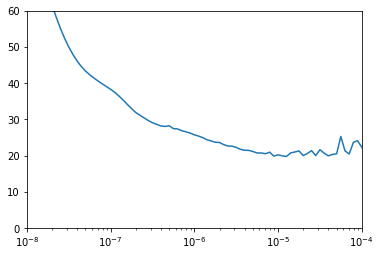

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 231ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 6s 214ms/step - loss: 25.7653 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 7s 224ms/step - loss: 22.0755 - mae: 22.5692
Epoch 4/500
30/30 [==============================] - 6s 205ms/step - loss: 20.4659 - mae: 20.9588
Epoch 5/500
30/30 [==============================] - 7s 219ms/step - loss: 19.7147 - mae: 20.2072
Epoch 6/500
30/30 [==============================] - 6s 215ms/step - loss: 19.3138 - mae: 19.8060
Epoch 7/500
30/30 [==============================] - 6s 215ms/step - loss: 18.6975 - mae: 19.1896 1s - loss: 18.6481 - mae: 
Epoch 8/500
30/30 [==============================] - 6s 210ms/step - loss: 18.1204 - mae: 18.6120
Epoch 9/500
30/30 [==============================] - 6s 215ms/step - loss: 18.1586 - mae: 18.6501
Epoch 10/500
30/30 [==============================] - 6s 213ms/step - loss: 17.9474 - mae: 

30/30 [==============================] - 2s 60ms/step - loss: 16.4495 - mae: 16.9380
Epoch 83/500
30/30 [==============================] - 2s 60ms/step - loss: 16.3616 - mae: 16.8499
Epoch 84/500
30/30 [==============================] - 2s 58ms/step - loss: 16.3639 - mae: 16.8521: 1s - loss: 1
Epoch 85/500
30/30 [==============================] - 2s 59ms/step - loss: 16.3910 - mae: 16.8796
Epoch 86/500
30/30 [==============================] - 2s 61ms/step - loss: 16.9704 - mae: 17.4595
Epoch 87/500
30/30 [==============================] - 2s 58ms/step - loss: 16.4951 - mae: 16.9841
Epoch 88/500
30/30 [==============================] - 2s 58ms/step - loss: 16.4492 - mae: 16.9382
Epoch 89/500
30/30 [==============================] - 2s 62ms/step - loss: 16.3350 - mae: 16.8231
Epoch 90/500
30/30 [==============================] - 2s 58ms/step - loss: 16.3628 - mae: 16.8514
Epoch 91/500
30/30 [==============================] - 2s 66ms/step - loss: 16.4489 - mae: 16.9379
Epoch 92/500
30/30 

30/30 [==============================] - 2s 65ms/step - loss: 15.9620 - mae: 16.4507: 1s - los
Epoch 164/500
30/30 [==============================] - 2s 73ms/step - loss: 15.9096 - mae: 16.3982
Epoch 165/500
30/30 [==============================] - 2s 59ms/step - loss: 15.9072 - mae: 16.3957
Epoch 166/500
30/30 [==============================] - 2s 66ms/step - loss: 15.8713 - mae: 16.3598
Epoch 167/500
30/30 [==============================] - 2s 81ms/step - loss: 15.8845 - mae: 16.3730
Epoch 168/500
30/30 [==============================] - 2s 73ms/step - loss: 15.9534 - mae: 16.4420
Epoch 169/500
30/30 [==============================] - 2s 65ms/step - loss: 15.9078 - mae: 16.3963
Epoch 170/500
30/30 [==============================] - 2s 60ms/step - loss: 15.9356 - mae: 16.4241
Epoch 171/500
30/30 [==============================] - 2s 61ms/step - loss: 15.8734 - mae: 16.3617
Epoch 172/500
30/30 [==============================] - 2s 65ms/step - loss: 15.8791 - mae: 16.3675
Epoch 173/500


30/30 [==============================] - 2s 60ms/step - loss: 15.5431 - mae: 16.0306
Epoch 245/500
30/30 [==============================] - 2s 61ms/step - loss: 15.5329 - mae: 16.0205
Epoch 246/500
30/30 [==============================] - 2s 65ms/step - loss: 15.5456 - mae: 16.0334
Epoch 247/500
30/30 [==============================] - 2s 65ms/step - loss: 15.5177 - mae: 16.0055
Epoch 248/500
30/30 [==============================] - 2s 62ms/step - loss: 15.7019 - mae: 16.1901
Epoch 249/500
30/30 [==============================] - 2s 62ms/step - loss: 15.5448 - mae: 16.0326
Epoch 250/500
30/30 [==============================] - 2s 63ms/step - loss: 15.4879 - mae: 15.9755
Epoch 251/500
30/30 [==============================] - 2s 65ms/step - loss: 15.5514 - mae: 16.0391
Epoch 252/500
30/30 [==============================] - 2s 60ms/step - loss: 15.6488 - mae: 16.1370
Epoch 253/500
30/30 [==============================] - 2s 62ms/step - loss: 15.4947 - mae: 15.9822
Epoch 254/500
30/30 [===

30/30 [==============================] - 2s 67ms/step - loss: 15.2810 - mae: 15.7681
Epoch 327/500
30/30 [==============================] - 2s 63ms/step - loss: 15.2270 - mae: 15.7137
Epoch 328/500
30/30 [==============================] - 2s 66ms/step - loss: 15.2088 - mae: 15.6957
Epoch 329/500
30/30 [==============================] - 2s 67ms/step - loss: 15.1238 - mae: 15.6102
Epoch 330/500
30/30 [==============================] - 2s 66ms/step - loss: 15.1228 - mae: 15.6095
Epoch 331/500
30/30 [==============================] - 2s 69ms/step - loss: 15.1018 - mae: 15.5883
Epoch 332/500
30/30 [==============================] - 2s 61ms/step - loss: 15.0733 - mae: 15.5597
Epoch 333/500
30/30 [==============================] - 2s 62ms/step - loss: 15.1683 - mae: 15.6551
Epoch 334/500
30/30 [==============================] - 2s 60ms/step - loss: 15.0553 - mae: 15.5415
Epoch 335/500
30/30 [==============================] - 2s 61ms/step - loss: 15.0717 - mae: 15.5579
Epoch 336/500
30/30 [===

30/30 [==============================] - 2s 66ms/step - loss: 14.7625 - mae: 15.2482
Epoch 409/500
30/30 [==============================] - 2s 63ms/step - loss: 14.7904 - mae: 15.2758: 1s - loss: 14.28
Epoch 410/500
30/30 [==============================] - 2s 64ms/step - loss: 15.0459 - mae: 15.5326
Epoch 411/500
30/30 [==============================] - 2s 60ms/step - loss: 15.4856 - mae: 15.9727: 0s - loss: 15.2957 - mae: 15.781 - ETA: 0s - loss: 15.3490 - 
Epoch 412/500
30/30 [==============================] - 2s 64ms/step - loss: 14.8715 - mae: 15.3581
Epoch 413/500
30/30 [==============================] - 2s 65ms/step - loss: 14.8817 - mae: 15.3675: 0s - loss: 14.8273 - mae: 15.3
Epoch 414/500
30/30 [==============================] - 2s 63ms/step - loss: 14.9464 - mae: 15.4326
Epoch 415/500
30/30 [==============================] - 2s 62ms/step - loss: 14.8514 - mae: 15.3372
Epoch 416/500
30/30 [==============================] - 2s 61ms/step - loss: 14.8708 - mae: 15.3572
Epoch 417/

30/30 [==============================] - 2s 71ms/step - loss: 14.5519 - mae: 15.0378
Epoch 490/500
30/30 [==============================] - 2s 73ms/step - loss: 14.5158 - mae: 15.0014
Epoch 491/500
30/30 [==============================] - 2s 72ms/step - loss: 14.5099 - mae: 14.9958
Epoch 492/500
30/30 [==============================] - 2s 71ms/step - loss: 14.5547 - mae: 15.0403
Epoch 493/500
30/30 [==============================] - 2s 70ms/step - loss: 14.5609 - mae: 15.0468
Epoch 494/500
30/30 [==============================] - 2s 70ms/step - loss: 14.4595 - mae: 14.9456
Epoch 495/500
30/30 [==============================] - 2s 72ms/step - loss: 14.6354 - mae: 15.1214
Epoch 496/500
30/30 [==============================] - 2s 72ms/step - loss: 14.5060 - mae: 14.9919
Epoch 497/500
30/30 [==============================] - 2s 73ms/step - loss: 14.5556 - mae: 15.0414
Epoch 498/500
30/30 [==============================] - 2s 71ms/step - loss: 14.4745 - mae: 14.9601
Epoch 499/500
30/30 [===

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

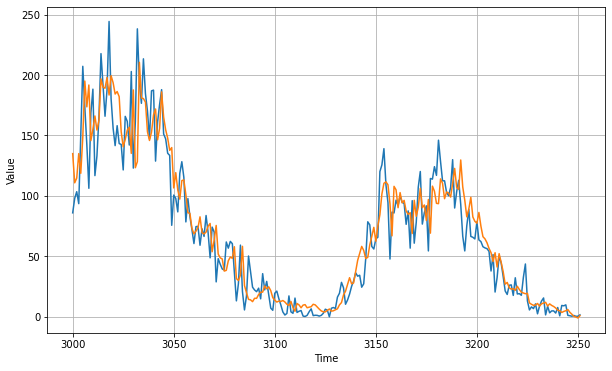

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.595944

<Figure size 432x288 with 0 Axes>

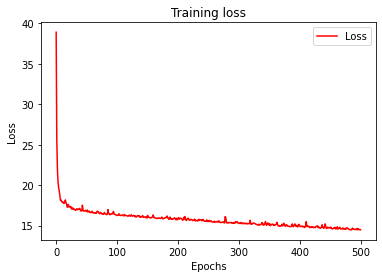

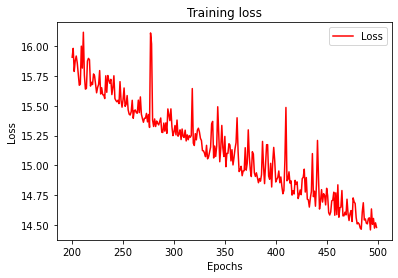

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [15]:
print(rnn_forecast)

[ 1.34982437e+02  1.10826111e+02  1.14787292e+02  1.34988525e+02
  1.18712616e+02  1.48785263e+02  1.95015091e+02  1.73662598e+02
  1.91737289e+02  1.45742325e+02  1.55111954e+02  1.66134598e+02
  1.54482727e+02  1.62457611e+02  1.96816971e+02  1.89916397e+02
  1.89069672e+02  1.98004440e+02  1.83453949e+02  1.99418396e+02
  1.93671677e+02  1.84285736e+02  1.86331848e+02  1.82100372e+02
  1.53079483e+02  1.40620850e+02  1.46768097e+02  1.54407364e+02
  1.56809906e+02  1.35172302e+02  1.87676743e+02  1.23349907e+02
  1.28366898e+02  2.10495041e+02  1.81076767e+02  1.80508728e+02
  1.77582474e+02  1.53000778e+02  1.45870621e+02  1.52787811e+02
  1.67032440e+02  1.71890930e+02  1.46406342e+02  1.55829544e+02
  1.86056381e+02  1.65219620e+02  1.54714798e+02  1.47807739e+02
  1.37661407e+02  1.39990479e+02  1.06600571e+02  1.19253494e+02
  1.04945923e+02  9.73760300e+01  1.12634132e+02  1.13264442e+02
  1.01060341e+02  8.60888443e+01  8.56004562e+01  7.31620560e+01
  6.86045990e+01  7.09611